# Test of Structural Mechanics (3D)
This notebook is based on the `test2`, in fact it is the same as that, however this time it is done in 3D.


In [1]:
try:
    import pyakantu as pyaka
except:
    print("Error importing pyakantu, try the other one")
    import py11_akantu as pyaka
    
import copy
import numpy

Error importing pyakantu, try the other one


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

### Creating the Mesh

In [3]:
# Create a mesh for the 2 dimensional case
beam = pyaka.Mesh(3)

We now create the connectivity array for the beam.

In [4]:
beam.addConnectivityType(pyaka._bernoulli_beam_3)

We need a `MeshAccessor` in order to change the size of the mesh entities.

In [5]:
beamAcc = pyaka.MeshAccessor(beam)

Now we create the array to store the nodes and the connectivities and give them their size. 

In [6]:
beamAcc.resizeConnectivity(3, pyaka._bernoulli_beam_3)
beamAcc.resizeNodes(4)

#### Setting the Nodes

In [7]:
Nodes = beam.getNodes()
Nodes[0, :] = [0., 0., 0.]
Nodes[1, :] = [1., 0., 0.]
Nodes[2, :] = [2., 0., 0.]
Nodes[3, :] = [3., 0., 0.]

#### Setting the Connections

In [8]:
Conn = beam.getConnectivity(pyaka._bernoulli_beam_3)
Conn[0, :] = [0, 1]
Conn[1, :] = [1, 2]
Conn[2, :] = [2, 3]

#### Ready
We have to make the mesh ready.

In [9]:
beamAcc.makeReady()

#### Setting the Extra Normals

We first test if the extra normals are here, however we expect them to be missing.

In [10]:
if(beam.hasExtraNormal(pyaka._bernoulli_beam_3)):
    print("The 'extra_normal' are pressent, which is kind of strange")
else:
    print("As we have expected the 'extra_normal' are not present.")

As we have expected the 'extra_normal' are not present.


 We will now create them, fpr the Bernoulli Beam in 3 dimensions.
 Note that they are only needed in three dimensions and not if the problem is in two dimensions.

In [11]:
eNorm = beam.makeExtraNormal(pyaka._bernoulli_beam_3)

Now setting the extra normals.

The format of the normals are a bit special.
Each element need one to compute a basis at its tip.
Thus the requirement is, that during the computation the `extra_normal`, that is associated to an element, must never become parallel to the connection vector connecting the two nodes marking the ends of the element.

Thus using the vector $\vec{n} = \left(1.0,\, 0.0,\, 0.0\right)$, is an error, since it is parallel to the connection vector.
Another choice would be $\vec{n} = \left(0.0,\, 0.0,\, 1.0\right)$ or any other.


In [12]:
for i in range(eNorm.shape[0]):
    eNorm[i, :] = [0.0, 0.0, 1.0]

In [13]:
beam.makeExtraNormal(pyaka._bernoulli_beam_3)

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

### Creating the Model

In [14]:
model = pyaka.StructuralMechanicsModel(beam)

#### Setting up the Modell

##### Creating and Inserting the Materials

In [15]:
mat1 = pyaka.StructuralMaterial()
mat1.E = 1e9
mat1.rho = 1.
mat1.I = 1.
mat1.Iz = 1.
mat1.Iy = 1.
mat1.A = 1.
mat1.GJ = 1.
mat1ID = model.addMaterial(mat1)

In [16]:
mat2 = pyaka.StructuralMaterial()
mat2.E = 1e9
mat2.rho = 1.
mat2.I = 1.
mat2.Iz = 1.
mat2.Iy = 1.
mat2.A = 1.
mat2.GJ = 1.
mat2ID = model.addMaterial(mat2)

In [17]:
mat3 = pyaka.StructuralMaterial()
mat3.E = mat2.E / 100000
mat3.rho = 1.
mat3.I = 1.
mat3.Iz = 1.
mat3.Iy = 1.
mat3.A = mat2.A / 100
mat3.GJ = 1.
mat3ID = model.addMaterial(mat3)

##### Initializing the Model

In [18]:
model.initFull(pyaka.AnalysisMethod._implicit_dynamic)

##### Assigning the Materials

In [19]:
materials = model.getElementMaterialMap(pyaka.ElementType._bernoulli_beam_3)

In [20]:
materials[0][0] = mat2ID
materials[1][0] = mat2ID
materials[2][0] = mat2ID

##### Setting Boundaries

In [21]:
# Neumann
#  Apply a force of `10` at the last (right most) node.
forces = model.getExternalForce()
forces[:] = 0
forces[2, 0] = 100.

In [22]:
# Dirichlets
# Block all dofs of the first node, since it is fixed.
#  All other nodes have no restrictions
boundary = model.getBlockedDOFs()
boundary[0, :] = True
boundary[1, :] = False
boundary[2, :] = False
boundary[3, :] = False
#boundary[2, 0] = True

### Solving the System

In [23]:
# Set up the system
deltaT = 1e-9
model.setTimeStep(deltaT)
solver = model.getNonLinearSolver()
solver.set("max_iterations", 100)
solver.set("threshold", 1e-8)
solver.set("convergence_type", pyaka.SolveConvergenceCriteria.solution)

In [24]:
# Perform N time steps.
#  At each step records the displacement of all three nodes in x direction.
N = 10000 * 60

disp0 = np.zeros(N)
disp1 = np.zeros(N)
disp2 = np.zeros(N)
disp3 = np.zeros(N)
times = np.zeros(N)
switchT = None
switchEnd = None

softDuration = 1000
SoftStart = (N // 2) - softDuration // 2
SoftEnd = SoftStart + softDuration
if(softDuration > 0):
    softFactor = (model.getMaterialByID(mat3ID).E / model.getMaterialByID(mat2ID).E ) ** (1.0 / softDuration)



for i in range(N):
    times[i] = deltaT * i
    
    if((SoftStart <= i <= SoftEnd) and (softDuration > 0)):
        if switchT is None:
            switchT = times[i]
        elif(i == SoftEnd):
            switchEnd = times[i]
        #
        mat2.E *= softFactor
        newMat = model.addMaterial(mat2)
        materials[1][0] = newMat
    #
    
    model.solveStep()
    disp = model.getDisplacement()
    disp0[i] = disp[0, 0]
    disp1[i] = disp[1, 0]
    disp2[i] = disp[2, 0]
    disp3[i] = disp[3, 0]

disps = [disp0, disp1, disp2, disp3]
maxMin = [-1.0, 1.0]

for d in disps:
    maxMin[0] = max(np.max(d), maxMin[0])
    maxMin[1] = min(np.min(d), maxMin[1])

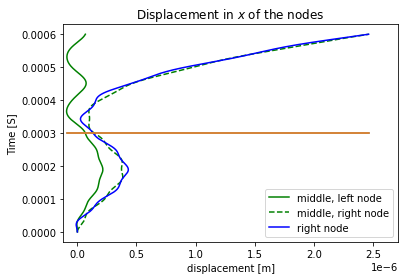

In [25]:
#plt.plot(disp0, times, color='k', label = "left node (fix)")
plt.plot(disp1, times, color='g', label = "middle, left node")
plt.plot(disp2, times, color='g', linestyle = '--', label = "middle, right node")
plt.plot(disp3, times, color='b', label = "right node")

if(softDuration > 0):
    plt.plot((maxMin[1], maxMin[0]), (switchT, switchT),)
    plt.plot((maxMin[1], maxMin[0]), (switchEnd, switchEnd), )

plt.title("Displacement in $x$ of the nodes")
plt.ylabel("Time [S]")
plt.xlabel("displacement [m]")

plt.xlim((maxMin[1] * 1.3, maxMin[0] * 1.1))

plt.legend()

plt.show()

If the softening is disabled, then the displacement looks wierd.
Because the displacement first increases and then decreases.
In this case `softDuration > 0` holds.

However if the softening is enabled, it looks rather good.
The left middle node will start to vibrate, because it is not pulled in the other direction.


